In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from google.colab import files

import math
import os

# Embedded Reber Grammar Generator

In [89]:
class ReberGrammar():
    def __init__(self):
        self.chars='BTSXPVE'
        self.graph = [[(1,5),('T','P')] , [(1,2),('S','X')],
                      [(3,5),('S','X')], [(6,),('E')],
                      [(3,2),('V','P')], [(4,5),('V','T')]]

    
    def in_grammar(self, word):
        if word[0] != 'B':
            return False
        node = 0    
        for c in word[1:]:
            transitions = self.graph[node]
            try:
                node = transitions[0][transitions[1].index(c)]
            except ValueError: # using exceptions for flow control in python is common
                return False
        return True        
        
    def sequenceToWord(self, sequence):
        """
        converts a sequence (one-hot) in a reber string
        """
        reberString = ''
        for s in sequence:
            index = np.where(s==1.)[0][0]
            reberString += self.chars[index]
        return reberString
        
    def generateSequences(self, minLength):
        while True:
            inchars = ['B']
            node = 0
            outchars = []    
            while node != 6:
                transitions = self.graph[node]
                i = np.random.randint(0, len(transitions[0]))
                inchars.append(transitions[1][i])
                outchars.append(transitions[1])
                node = transitions[0][i]
            if len(inchars) > minLength:  
                return inchars, outchars


    def get_one_example(self, minLength):
        inchars, outchars = self.generateSequences(minLength)
        inseq = []
        outseq= []
        for i,o in zip(inchars, outchars): 
            inpt = np.zeros(7)
            inpt[self.chars.find(i)] = 1.     
            outpt = np.zeros(7)
            for oo in o:
                outpt[self.chars.find(oo)] = 1.
            inseq.append(inpt)
            outseq.append(outpt)
        return inseq, outseq


    def get_char_one_hot(self, char):
        char_oh = np.zeros(7)
        for c in char:
            char_oh[self.chars.find(c)] = 1.
        return [char_oh] 


    def get_n_examples(self, n, minLength=10):
        examples = []
        for i in range(n):
            examples.append(self.get_one_example(minLength))
        return examples


class EmbeddedReberGrammar(ReberGrammar):
    def __init__(self):
        super().__init__()
        self.emb_chars = "TP"


    def get_one_embedded_example(self, minLength=10):
        i, o = self.get_one_example(minLength)
        emb_char = self.emb_chars[np.random.randint(0, len(self.emb_chars))]
        new_in = self.get_char_one_hot('B')
        new_in += self.get_char_one_hot(emb_char)
        new_out= self.get_char_one_hot(self.emb_chars)
        new_out+= self.get_char_one_hot('B')
        new_in += i
        new_out += o
        new_in += self.get_char_one_hot('E')
        new_in += self.get_char_one_hot(emb_char)
        new_out += self.get_char_one_hot(emb_char)
        new_out += self.get_char_one_hot('E')
        return new_in, new_out
        
    def get_n_embedded_examples(self, n, minLength=10):
        example_in = []
        example_out = []
        for i in range(n):
            e_in, e_out = self.get_one_embedded_example(minLength)
            example_in.append(np.expand_dims(np.array(e_in), axis=0))
            example_out.append(np.expand_dims(np.array(e_out), axis=0))
        return example_in, example_out


# Utility Functions


In [74]:
def download_to_local():
    !zip -r Erg_Problem.zip Erg_Problem
    files.download('Erg_Problem.zip')

def create_tf_dataset(X, Y):
    dataset = tf.data.Dataset.from_generator(lambda: X, 
                                             X[0][0].dtype,
                                             tf.TensorShape([None, None, 7]))
    labels = tf.data.Dataset.from_generator(lambda: Y, 
                                            Y[0][0].dtype,
                                            tf.TensorShape([None, None, 7]))
    dataset = tf.data.Dataset.zip((dataset, labels))

    return dataset

# Model Class

In [97]:
class ErgLSTM():
    def __init__(self, hidden_dim=10, output_dim=7, checkpoint_dir='Erg_Problem'):
        model = keras.models.Sequential()
        model.add(keras.layers.LSTM(hidden_dim, return_sequences=True))
        model.add(keras.layers.TimeDistributed(
            keras.layers.Dense(output_dim, activation='sigmoid')))

        model.compile(
            loss=keras.losses.binary_crossentropy,
            optimizer=keras.optimizers.RMSprop()
        )   
        
        self.checkpoint_dir = checkpoint_dir
        self.model = model


    def train(self, train_data, val_data, batch_size=16, epochs=100,
              download=True, clean_start=True):
        if os.path.exists(self.checkpoint_dir) and clean_start:
            !rm -r Erg_Problem/
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        my_callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(
                    self.checkpoint_dir,'model.{epoch:02d}.{loss:04f}.ckpt'),
                save_weights_only=True),
            keras.callbacks.TensorBoard(
                log_dir=os.path.join(self.checkpoint_dir, "logs")),
        ]

        hist = self.model.fit(
            train_data, batch_size=batch_size, epochs=epochs, 
            callbacks=my_callbacks, validation_data=val_data)
        
        if download:
            download_to_local()
        
        return hist


    def evaluate(self, test_data):
        if not os.path.exists(self.checkpoint_dir):
            uploaded = files.upload()  # please upload the checkpoints in zip format
            !unzip ERG_Problem.zip
        latest = tf.train.latest_checkpoint(self.checkpoint_dir)
        self.model.load_weights(latest)

        self.model.evaluate(test_data)


# Train

In [98]:
erg_lstm = ErgLSTM()
erg_gen = EmbeddedReberGrammar()

X_train, Y_train = erg_gen.get_n_embedded_examples(256)
train_dataset = create_tf_dataset(X_train, Y_train)

# validation data
X_val, Y_val = erg_gen.get_n_embedded_examples(128)
val_dataset = create_tf_dataset(X_val, Y_val)

erg_lstm.train(train_dataset, val_dataset, 
                batch_size=32, epochs=100, download=True)


# Evaluate

In [99]:
X_test, Y_test = erg_gen.get_n_embedded_examples(256)
test_dataset = create_tf_dataset(X_test, Y_test)

erg_lstm.evaluate(test_dataset)


def check_accuracy(X_test, Y_test, model):
    round_fn = np.vectorize(round)
    err = 0
    for x, y in zip(X_test, Y_test):
        ans = np.squeeze(y)
        pred = np.squeeze(model(x).numpy())
        pred = round_fn(pred)

        err += np.sum(np.abs(ans - pred))

    return err

print('error: ', check_accuracy(X_test, Y_test, erg_lstm.model))

print('input: \n', X_test[1])
print('target: \n', Y_test[1])
pred = erg_lstm.model(X_test[1]).numpy()
pred = np.vectorize(round)(pred)
print('pred: \n', pred)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

256/256 [==============================] - 0s 2ms/step - loss: 3.6569e-06
error:  0.0
[[[1. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0. 0. 0.]]]
[[[0. 1. 0. 0. 1. 0. 0.]
  [1. 0. 0. 0. 0. 0.

# Full FORCE

In [172]:
# First, you have to upload the full force class definition file.
import FF_for_Erg as FF

def ERG_Problem_FF(generator=None, dt=1, N=256, minLength=10):
    """First Trial: make the second component hint input to Full FORCE.
    """
    if not generator:
        raise RuntimeError('generator cannot be None!')
    del dt  # unused
    inp, target = generator.get_n_embedded_examples(N, minLength=minLength)

    inp = [np.squeeze(x) for x in inp]
    target = [np.squeeze(x) for x in target]  # [T, 7] * N
    # hint input: 
    hint = []
    for x in target:
        
        if (x[-2] == [0., 1., 0., 0., 0., 0., 0.]).all():  # T
            h = np.zeros(x.shape[0])
        else:  # P
            h = np.ones(x.shape[0])
        hint.append(np.expand_dims(h, axis=1))

    return inp, target, hint

{'network_size': 500, 'dt': 1, 'tau': 1, 'noise_std': 0, 'g': 1, 'p': 1, 'inp_scale': 1, 'out_scale': 1, 'bias_scale': 0, 'init_act_scale': 1, 'num_epochs': 10, 'ff_steps_per_update': 1, 'ff_alpha': 2, 'ff_init_trials': 3, 'test_init_trials': 1}
Initializing...
Training network...
epoch 1 of 10,  256 examples: 
.

/content/FF_for_ap.py:304: RuntimeWarning: invalid value encountered in true_divide
  (w_err_ratio, np.squeeze(w_err_plus / w_err)))


..........mean epoch error:  0.24312376400949692

epoch 2 of 10,  256 examples: 
...........mean epoch error:  0.11938306949592956

epoch 3 of 10,  256 examples: 
...........mean epoch error:  0.10790666642551462

epoch 4 of 10,  256 examples: 
...........mean epoch error:  0.10089535250198495

epoch 5 of 10,  256 examples: 
...........mean epoch error:  0.09678302665732602

epoch 6 of 10,  256 examples: 
...........mean epoch error:  0.09197769283799401

epoch 7 of 10,  256 examples: 
...........mean epoch error:  0.09296307864256434

epoch 8 of 10,  256 examples: 
...........mean epoch error:  0.09166817929075366

epoch 9 of 10,  256 examples: 
...........mean epoch error:  0.0903204674158245

epoch 10 of 10,  256 examples: 
...........mean epoch error:  0.0866247940940696

Done training!


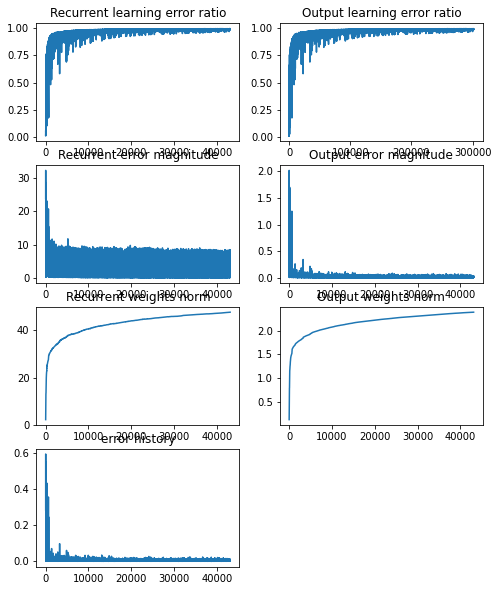

In [173]:
import importlib
importlib.reload(FF)
FF_hp = FF.create_parameters(dt=1, network_size=500)
FF_hp['num_epochs'] = 10
FF_hp['ff_steps_per_update'] = 1
FF_hp['ff_alpha'] = 2
print(FF_hp)
erg_gen = EmbeddedReberGrammar()

FF_rnn = FF.RNN(FF_hp, 7, 7)  # 1 input since sencond component is set to hint.
FF_rnn.train(ERG_Problem_FF, monitor_training=1, generator=erg_gen, N=256, minLength=10)

In [174]:
inp, targ, hint = ERG_Problem_FF(generator=erg_gen, dt=1, N=256, minLength=5)


def check_accuracy_FF(X_test, Y_test, model, func, **kwargs):
    func = np.vectorize(func)
    err = 0
    for x, y in zip(X_test, Y_test):
        pred, _ = model.run(x, record_flag=1, output_activation='sigmoid')
        pred = func(pred, **kwargs)

        err += np.sum(np.abs(y - pred))

    return err

def threshold(x, thresh=0.5):
    return 1. if x > thresh else 0.


In [175]:
index = 210
z, _ = FF_rnn.run(inp[index], record_flag=1)
z = np.vectorize(threshold)(z, 0.6)
print('input: ', inp[index], sep='\n')
print('target: ', targ[index], sep='\n')
print('pred: ', z, sep='\n')

print(check_accuracy_FF(inp, targ, FF_rnn, threshold, thresh=0.6))

print('err: ', np.sum(np.abs(targ[index] - z)))

input: 
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]]
target: 
[[0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
pred: 
[[0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
0.0
0.0
